<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/2020_6%E6%9C%882%E5%91%A8%E7%9B%AE_%E6%B8%A9%E5%BA%A6%E4%BB%98%E3%81%8Dsoftmax%E3%81%AB%E3%82%88%E3%82%8B%E8%92%B8%E7%95%99%E5%AE%9F%E9%A8%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ドライブとの連携**

In [12]:
from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント

Mounted at /content/gdrive


**インポート**

In [0]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Function

**GPU確認**

In [14]:
torch.cuda.is_available()

True

**cifarロード**

In [0]:
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

**教師モデルの定義**

In [0]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,  # チャネル入力
#                                      6,  # チャンネル出力
#                                      5,  # カーネルサイズ
#                                      1,  # ストライド (デフォルトは1)
#                                      0,  # パディング (デフォルトは0)
#                                      )
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 0)
        self.conv2 = torch.nn.Conv2d(32, 32, 3)
        self.conv3 = torch.nn.Conv2d(32, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 64, 3)
        
        self.dropout1 = torch.nn.Dropout2d(p=0.25)
        self.dropout2 = torch.nn.Dropout2d(p=0.5)

        self.pool = torch.nn.MaxPool2d(2, 2) 

        self.fc1 = torch.nn.Linear(64 * 5 * 5, 512)
        self.fc2 = torch.nn.Linear(512, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 64 * 5 * 5)
        x = f.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return  f.log_softmax(x)

教師モデルの学習はT=1で問題ない？
蒸留モデル作成時に教師モデルを推論するときに温度を上げ強調するという形でよいのだろうか。

In [0]:
if __name__ == '__main__':
    epoch = 130
    loader = load_cifar10()

    net: CNN = CNN()
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for e in range(epoch):
        
        ################################### 学習 #################################
        
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        history['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))
               ################################### 推論 #################################
              
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['train']):
                images = images.to(device) 
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 50000)
        print('train accuracy:{}'.format(acc))
        history['train_acc'].append(acc)

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        print('test accuracy:{}'.format(acc))
        history['test_acc'].append(acc)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/コード/teacher_model_weight.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path) # 保存

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

**温度付きSoftmaxは、蒸留モデル作成時の損失計算時に用いられるため。既に作成されたモデルのTをいじるという考え方で正しいと認識**

In [0]:
#####ドロップアウトを除いた推論用モデル#######
#ここで温度を変更して、softターゲットとする。


class T_CNN(torch.nn.Module):
    def __init__(self):
        super(T_CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 0)
        self.conv2 = torch.nn.Conv2d(32, 32, 3)
        self.conv3 = torch.nn.Conv2d(32, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 64, 3)
        
        self.dropout1 = torch.nn.Dropout2d(p=0.25)
        self.dropout2 = torch.nn.Dropout2d(p=0.5)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(64 * 5 * 5, 512) 
        self.fc2 = torch.nn.Linear(512, 10)

    def forward(self, x, T):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        x = x/T

        return f.softmax(x)

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = torch.nn.Linear(1024, 10)

    def forward(self, x, T):
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        x = x/T
        return f.log_softmax(x)

**教師モデルと生徒モデルのcross_entropyの損失関数の定義**

In [0]:
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()

    def forward(self, p, q):
        #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)です。
        # c = torch.max(q)
        loss = p*q
        loss = torch.sum(loss)
        loss*=-1
        return loss


# class LossFunction(nn.Module):
#     def __init__(self):
#       super(LossFunction, self).__init__()
#     def forward(self, inputs, targets):
#       loss = function(inputs, targets)
#       return loss

#softmaxの出力に0が含まれることで、logがnanを出していた。
#Pytorchでsoftmax -> logとする場合は、torch.nn.functional.log_softmaxを使うことで、nanを防ぐことができる。

#つまり今回の場合、生徒モデルが対数を取ることとなっていたので蒸留される生徒モデルにのみlog_softmaxを使う。

**保存した教師モデルの読み込み**

In [20]:
Tnet: T_CNN = T_CNN()
    
# 保存したモデルのパラメータ
param = torch.load('/content/gdrive/My Drive/コード/teacher_model_weight.pth')

# 保存したモデルにパラメータを当てはめる
Tnet.load_state_dict(param)

<All keys matched successfully>

**教師モデルの精度と速度の確認(動かしたいならGPU解除しような)**

In [21]:
import time
loader = load_cifar10()
t1 = time.time()

correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        outputs = Tnet(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

acc = float(correct / 10000)
print(acc)


t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.7364
経過時間：10.576042652130127


**温度ごとにおける生徒モデルの学習(のみ)**

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 0.1 ,Training log: 10 ,epoch：Loss: 132.35552978515625
0.484
temp: 0.1 ,Training log: 20 ,epoch：Loss: 147.4191131591797
0.502
temp: 0.1 ,Training log: 30 ,epoch：Loss: 68.90742492675781
0.4942
temp: 0.1 ,Training log: 40 ,epoch：Loss: 57.61478042602539
0.4974
temp: 0.1 ,Training log: 50 ,epoch：Loss: 101.80387878417969
0.4978
Files already downloaded and verified
Files already downloaded and verified
temp: 0.5 ,Training log: 10 ,epoch：Loss: 82.12960815429688
0.5301
temp: 0.5 ,Training log: 20 ,epoch：Loss: 57.57966613769531
0.5296
temp: 0.5 ,Training log: 30 ,epoch：Loss: 45.96782302856445
0.5408
temp: 0.5 ,Training log: 40 ,epoch：Loss: 53.003684997558594
0.5389
temp: 0.5 ,Training log: 50 ,epoch：Loss: 44.36888122558594
0.5404
Files already downloaded and verified
Files already downloaded and verified
temp: 1.0 ,Training log: 10 ,epoch：Loss: 83.99095153808594
0.5165
temp: 1.0 ,Training log: 20 ,epoch：Loss: 66.637939453125
0.5419
temp: 1.0 ,Training log: 30 ,epoch：Loss: 72.9944915771484

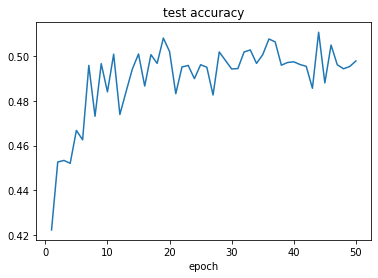

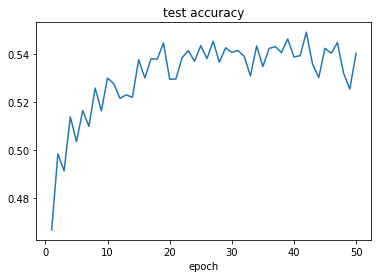

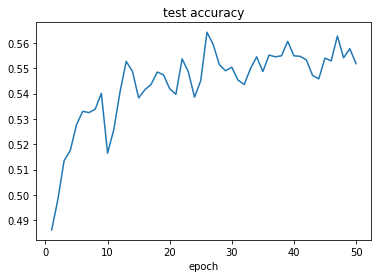

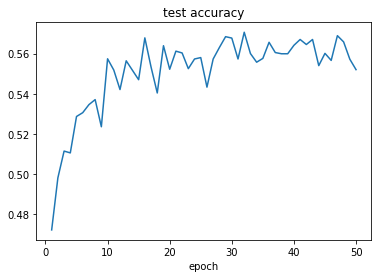

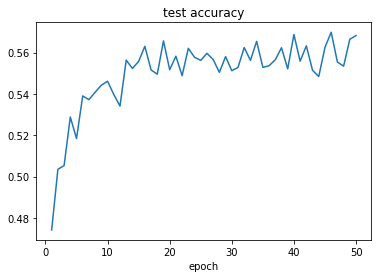

In [25]:
for i in range(0,21,5):
    if i==0:
      temp=0.1
    else:
      temp = i/10
    if __name__ == '__main__':
        # 学習回数
        history = {
          'train_loss': [],
          'test_loss': [],
          'test_acc': [],
          }
        epoch = 50

        net: MyNet = MyNet()
        loaders = load_cifar10()

        criterion = T_S_Closs_entropy()

        optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        net.to(device)
        Tnet.to(device)

        for e in range(1,epoch+1):

            """ Training Part"""
            loss = None
            net.train()
            for data, target in loaders['train']:
                
                data = data.to(device)
                target = target.to(device)

                max_model_outputs = Tnet(data,temp)
                data = data.view(-1, 32 * 32 * 3)
                output = net(data,temp)

                optimizer.zero_grad()

                loss = criterion(max_model_outputs,output)

                loss.backward()
                optimizer.step()


            net.eval()
            correct = 0
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in loaders['test']:
                    data = data.to(device) 
                    target = target.to(device)
                    data = data.view(-1, 32 * 32 * 3)
                    output = net(data,temp)
                    test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()
            history['test_acc'].append(correct / 10000)

            if e%10==0:
              print('temp: {} ,Training log: {} ,epoch：Loss: {}'.format(temp,e ,loss.item()))
              acc = float(correct / 10000)
              print(acc)
        
        #====== 保存 =======
        path = '/content/gdrive/My Drive/コード/weight_distillationNN_gc'+str(temp)+'.pth' # 保存先pathの設定
        torch.save(net.state_dict(), path) # 保存

        plt.figure()
        plt.plot(range(1, epoch+1), history['test_acc'])
        plt.title('test accuracy')
        plt.xlabel('epoch')
        plt.savefig('test_acc.png')

感想
温度が低すぎると、正解ラベルと同じような分布の比較となる。
しかし、学習する正解ラベルは精度72%の精度の低い正解モデルのため蒸留されるモデルも精度が低くなる。

一方で、0.1,0.5,1,1.5,2　の場合温度が高くなるにつれ、精度も高まっている印象を受ける。

温度の最善はあるのかどうかは不明。温度を高くしすぎるとソフトになりすぎて学習できる特徴が減るため、問題は生じると予想はしておく。